In [1]:
import re
import streamlit as st
from sympy.physics.continuum_mechanics import Beam
import sympy
from sympy import SingularityFunction
from sympy.plotting import plot
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

st.write("""
# Simple Beam Analysis

""")

st.sidebar.header('User Input Parameters')

def user_input_features(): 
    # Beam Length in Meters
    beam_length = st.sidebar.slider('Beam Length', 5.0, 25.0, 10.0, step=2.5)
    # Start Supports
    start_Support = st.sidebar.selectbox('Start Support',('Fix', 'Pin', 'Roller'))
    end_Support = st.sidebar.selectbox('End Support',('Fix', 'Pin'))

    #Point Load in kN
    point_load = st.sidebar.slider('Point Load Magnitude', 0.0, 25.0, 10.0, step=5.0)

    point_load_loc = st.sidebar.slider('Point Load Loc:', 0.0, beam_length, 3.0, step=2.5)
    
    # Udl load is in kN/m
    udl_load = st.sidebar.slider('UDL Magnitude', 0.0, 25.0, 5.0 ,step = 5.0)

    udl_start_loc = st.sidebar.slider('UDL Start Loc', 0.0, beam_length - 5.0, 0.0, step=2.5)
    udl_end_loc = st.sidebar.slider('UDL End Loc', udl_start_loc+2.5, beam_length, beam_length, step=2.5)

    #Point Load in kN-m
    moment_load = st.sidebar.slider('Moment Magnitude', -20.0, 20.0, 0.0, step=5.0)

    moment_loc = st.sidebar.slider('Moment Loc:', 0.0, beam_length, 4.0, step=2.5)

    
    data = {'beam_length': beam_length,
            'start_Support': start_Support,
            'end_Support': end_Support,
            'E': 25000.0,
            'Izz': 0.0005}

    features = pd.DataFrame(data, index=[0])
    beam_data = [beam_length, start_Support, end_Support]

    point_data = [point_load, point_load_loc]
    
    moment_data = [moment_load, moment_loc]
    
    UDL_data = [udl_load, udl_start_loc, udl_end_loc]

    return features, beam_data, point_data, moment_data, UDL_data

df, beam_data, point_data, moment_data, UDL_data = user_input_features()

st.subheader('User Input parameters')
st.write(df)

# Logic
E = 25000
I = 0.0005

#print(beam_data, point_data)

L = beam_data[0]
lt_sprt = beam_data[1]
rt_sprt = beam_data[2]

beam_inst = Beam(L, E, I)

def sympy_variable(x:str):
        return sympy.symbols(x)

def apply_end_support_loads(beam_inst, L):
    sympy_symbols = []
    beam_inst.bc_deflection = []
    beam_inst.bc_slope = []
    if lt_sprt == "Fix":
        R_0 = sympy_variable("R_0")
        M_0 = sympy_variable("M_0")
        sympy_symbols.append(R_0)
        sympy_symbols.append(M_0)
        beam_inst.apply_load(R_0, 0, -1)
        beam_inst.apply_load(M_0, 0, -2)
        beam_inst.bc_deflection.append((0,0))
        beam_inst.bc_slope.append((0,0))
    else:
        R_0 = sympy_variable("R_0")
        sympy_symbols.append(R_0)
        beam_inst.apply_load(R_0, 0, -1)
        beam_inst.bc_deflection.append((0,0))

    if rt_sprt == "Fix":
        r_end = sympy_variable("R_" + str(L))
        m_end = sympy_variable("M_" + str(L))
        sympy_symbols.append(r_end)
        sympy_symbols.append(m_end)
        beam_inst.apply_load(r_end, L, -1)
        beam_inst.apply_load(m_end, L, -2)
        beam_inst.bc_deflection.append((L,0))
        beam_inst.bc_slope.append((L,0))
    else:
        r_end = sympy_variable("R_" + str(L))
        sympy_symbols.append(r_end)
        beam_inst.apply_load(r_end, L, -1)
        beam_inst.bc_deflection.append((L,0))
    
    return sympy_symbols

reaction_symbols = apply_end_support_loads(beam_inst ,L)


beam_inst.apply_load(point_data[0], point_data[1], -1)
beam_inst.apply_load(moment_data[0], moment_data[1], -2)
beam_inst.apply_load(UDL_data[0], UDL_data[1], 0, end=UDL_data[2])


if len(reaction_symbols) == 4:
    beam_inst.solve_for_reaction_loads(reaction_symbols[0], reaction_symbols[1] ,reaction_symbols[2], reaction_symbols[3])
elif len(reaction_symbols) == 3:
    beam_inst.solve_for_reaction_loads(reaction_symbols[0], reaction_symbols[1] ,reaction_symbols[2])
else:
    beam_inst.solve_for_reaction_loads(reaction_symbols[0], reaction_symbols[1])




2022-06-16 15:21:40.920 INFO    numexpr.utils: NumExpr defaulting to 8 threads.
2022-06-16 15:21:45.531 
  command:

    streamlit run /home/abhimhamane/anaconda3/envs/streamlit-env/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]


In [35]:
#beam_inst.plot_slope()

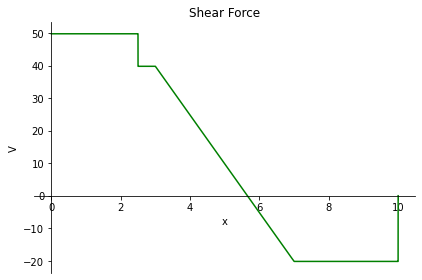

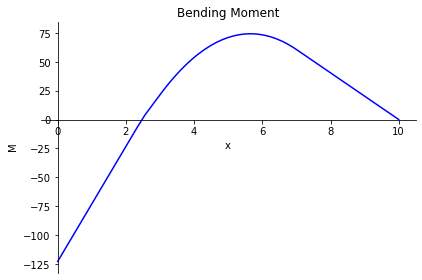

In [37]:
##### Cantilever Beam
L = 10.0
E = 25000
I = 0.000525

b1 = Beam(L, E, I)

R1 = sympy_variable("R_0")

M0 = sympy_variable("M_0")

r_end = sympy_variable("R_10")


b1.apply_load(R1, 0, -1)
b1.apply_load(M0, 0, -2)
b1.apply_load(r_end, L, -1)

b1.apply_load(10.0, 2.5, -1)
b1.apply_load(15.0, 3.0, 0, end=7)

b1.bc_deflection.append((0,0))
b1.bc_deflection.append((L, 0))
b1.bc_slope.append((0,0))

b1.solve_for_reaction_loads(R1 ,M0, r_end)
b1.reaction_loads



#b1.solve_for_reaction_loads(R1 ,M0, R2)
#v= b1.plot_shear_force()
sh_eq = b1.shear_force()
bm_eqn = b1.bending_moment()
#slp_eqn = b1.slope()
#defl_eqn = b1.deflection()
ax_x = np.arange(0, L, 0.05)
#print(ax_x)
x = sympy.symbols("x")
shear_y = []

for i in ax_x:
    shear_y.append(sh_eq.subs(x, i))

b1.plot_shear_force()
b1.plot_bending_moment()


R_10

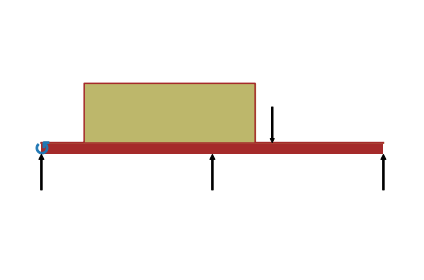

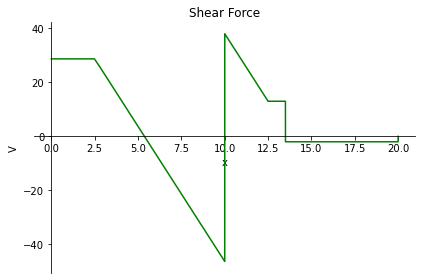

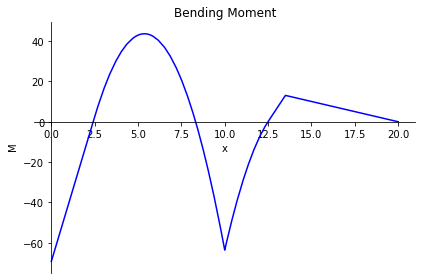

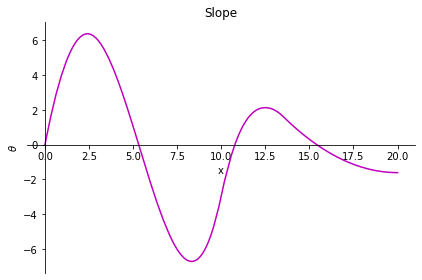

In [25]:
L = 20.0
E = 25000
I = 0.000525

## Continuous Beam ##
cont_beam = Beam(L, E,I)
left_sprt = "Fixed"
right_sprt = "Roller"

num_spans = 2
num_sprts = num_spans + 1
sprt_spacing = L/num_spans

sprt_locations = list(np.linspace(0, L, num_sprts))

beam_viz = Beam(L,E,I)

beam_viz.apply_support(0, "fixed")


for loc in sprt_locations[1:-1]:
    beam_viz.apply_support(loc, "roller")

beam_viz.apply_support(L, "roller")

#cont_pen = beam_viz.draw()
#cont_pen.show()
beam_sprt = beam_viz.applied_loads

sprt_symbs = []
sprt_order = []
sprt_start_loc = []

for spr in beam_sprt:
    sprt_symbs.append(spr[0])
    sprt_order.append(spr[2])
    sprt_start_loc.append(spr[1])

for i in range(len(sprt_order)):
    if sprt_order[i] == -1:
        cont_beam.apply_load(sprt_symbs[i], sprt_start_loc[i], -1)
        cont_beam.bc_deflection.append((sprt_start_loc[i], 0))
    elif sprt_order[i] == -2:
        cont_beam.apply_load(sprt_symbs[i], sprt_start_loc[i], -2)
        cont_beam.bc_slope.append((sprt_start_loc[i], 0))


cont_beam.apply_load(10, 2.5, 0, 12.5)
cont_beam.apply_load(15, 13.5, -1)

_pen = cont_beam.draw()
_pen.show()

cont_beam.solve_for_reaction_loads(sprt_symbs[0], sprt_symbs[1], sprt_symbs[2], sprt_symbs[3])

cont_beam.reaction_loads
cont_beam.plot_shear_force()
cont_beam.plot_bending_moment()
cont_beam.plot_slope()
#Deflection does not work

IndexError: list index out of range

In [58]:
for  b1 in beam_sprt:
    sprt_symbs.append(b1[0])

In [74]:
sprt_symbs

[R_0,
 M_0,
 R_5.00000000000000,
 R_10.0000000000000,
 R_15.0000000000000,
 R_20.0000000000000]